# Imports

In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    mat_path = '/Home/siv30/wad005/master/GRB/MATLAB/andrey_mezentsev/'
else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    mat_path = '/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/'
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time
import scipy.io
import pandas as pd

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

# Notes
    tlagg = 0.472 s

# Background extraction

In [64]:
tlagg = 0.476 #s
T0 = datetime.fromisoformat('2019-03-05T13:05:19.816')
T0 += timedelta(seconds=tlagg)
df = harvest_data(fn='2019_3_5_13_5_19',T0='2019-03-05T13:05:19.816')
df['tus'] += tlagg
tus = df['tus'].to_numpy()
len(tus),type(tus)

dau/det starting from index 1
tus array given in seconds
safety time:  0.175 % removed
sorted by tus (s)


(42182, numpy.ndarray)

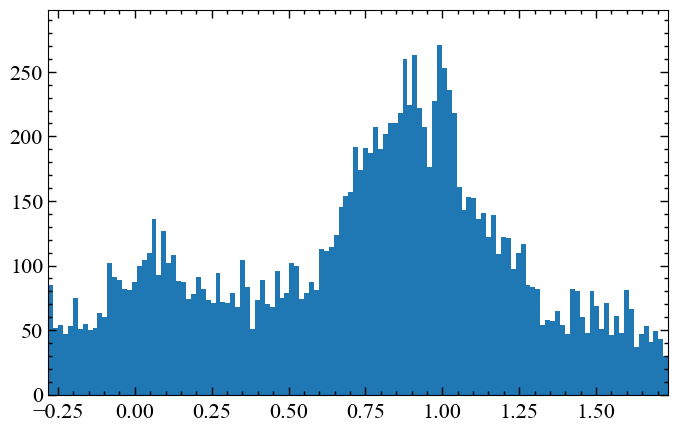

In [65]:
binsize = 0.016
i,j=np.searchsorted(tus,-2),np.searchsorted(tus,2)
bins = np.arange(min(tus[i:j]),max(tus[i:j])+binsize,binsize)
plt.hist(tus[i:],bins=bins)
plt.show()

In [66]:
df_asim_burst = df.truncate(before=i,after=j-1)
tus_burst =df_asim_burst['tus'].to_numpy()
print(tus_burst[0],tus_burst[-1])

-0.28140672200000005 1.7272319170000001


last bkg bin: -0.1054


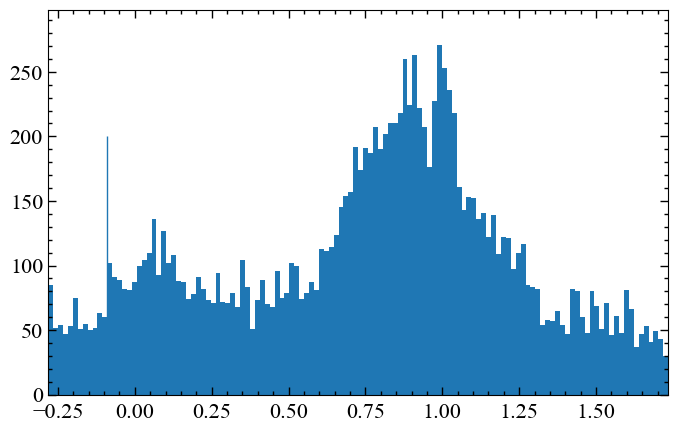

In [67]:
bins_burst = np.arange(min(tus_burst),max(tus_burst)+binsize,binsize)
plt.hist(tus_burst,bins=bins_burst)
plt.vlines(x=bins_burst[12],ymin=0,ymax=200)
print(f'last bkg bin: {round(bins_burst[11],4)}')
plt.show()

In [68]:
jx = df_asim_burst.index[0] + np.searchsorted(tus_burst,bins_burst[11])
df_asim_bkg = df_asim_burst.truncate(after=jx)
df_asim_burst = df_asim_burst.truncate(before=jx)
tus_bkg = df_asim_bkg['tus'].to_numpy()
tus_burst = df_asim_burst['tus'].to_numpy()

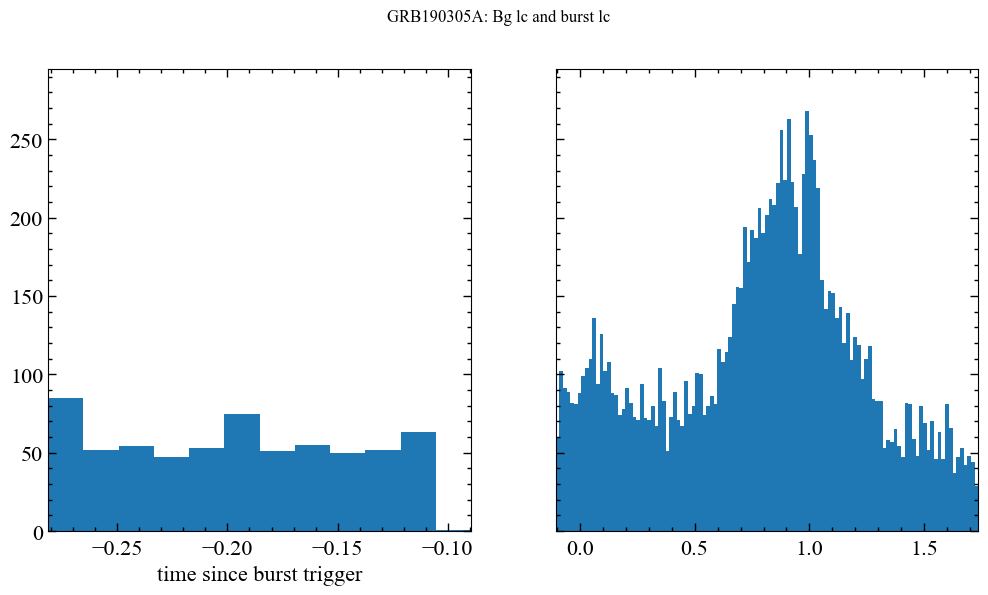

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(12, 6))
fig.suptitle('GRB190305A: Bg lc and burst lc')
ax1.hist(tus_bkg,bins=np.arange(min(tus_bkg),max(tus_bkg)+binsize,binsize))
ax2.hist(tus_burst,bins=np.arange(min(tus_burst),max(tus_burst)+binsize,binsize))
ax1.set_xlabel("time since burst trigger")
plt.show()

# Andrey data

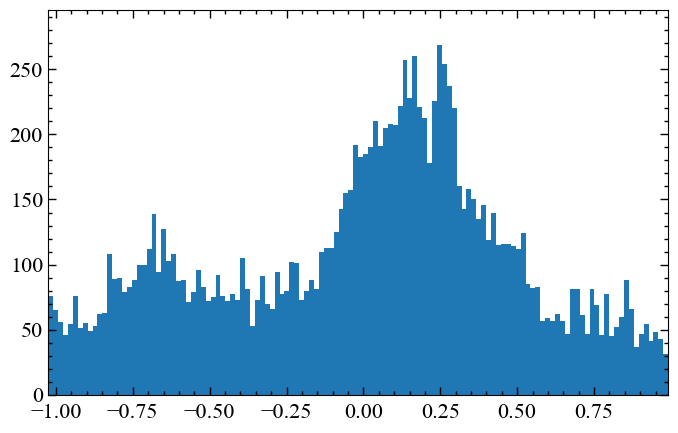

In [82]:
df_asim = pd.read_csv(mat_path_andrey+'GRB190305A.csv')
binsize = 0.016

tlagg = -0.304296875
df_asim['tus'] /= 1e6
df_asim['tus'] += tlagg
tus = df_asim['tus'].to_numpy(dtype=np.float64)
bins = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
plt.hist(tus,bins=bins)
plt.show()

In [83]:
T0 = datetime.fromisoformat('2019-03-05T13:05:20.355640') + timedelta(seconds=tlagg)
print(T0)
df_asim = make_adr(df_asim)
df_asim.sort_values(by=['adr','tus'],inplace=True,ignore_index=True)
df_asim.drop(df_asim[df_asim['typ']==3].index, inplace = True) #removed valleys
df_asim.head()

2019-03-05 13:05:20.051343


,tus,dau,det,typ,erg,adr
0,-1.024690,1,1,0,1768,1
1,-1.022637,1,1,0,66,1
2,-1.021662,1,1,0,1925,1
3,-1.020466,1,1,0,26,1
4,-1.016246,1,1,0,72,1


In [84]:
df_asim['tus'] *= 1e6 #converting to us
tus,erg,dau,det = df_asim['tus'].to_numpy(dtype=np.float64),df_asim['erg'].to_numpy(),df_asim['dau'].to_numpy(),df_asim['det'].to_numpy()
keV,abc = convert_erg(erg,dau,det,T0)
df_asim['keV'] = keV

st,dt = get_st(df_asim),get_dt(df_asim) #st returned in us
df_asim['st']=st
df_asim['dt']=dt

flag = get_flag(df_asim)
df_asim['flag'] = flag
df_asim.drop(df_asim[get_flag(df_asim)].index,inplace=True)
df_asim.sort_values(by='tus',inplace=True,ignore_index=True)
df_asim['tus'] /= 1e6
print('Safety time: ',np.round((len(np.where(flag==True))/len(tus))*100,3), '% removed')
print('sorted by tus (s)')

Safety time:  0.007 % removed
sorted by tus (s)


In [59]:
df_asim

,tus,dau,det,typ,erg,adr,keV,st,dt,flag
0,-1.024690,1,1,0,1768,1,29748.0297,25.000000,0.0,False
1,-1.023829,4,3,0,47,12,580.5769,1.161154,635.0,False
2,-1.023805,4,2,0,32,11,384.4049,0.000000,659.0,False
3,-1.023219,3,1,0,52,7,1092.4913,1.123322,1245.0,False
4,-1.022637,3,1,0,382,7,7913.3610,11.661378,582.0,False
...,...,...,...,...,...,...,...,...,...,...
13438,0.982041,4,3,0,1330,12,20647.2768,23.000000,3.0,False
13439,0.982607,2,1,0,67,4,478.3289,1.566578,571.0,False
13440,0.983736,3,3,0,506,9,10589.1663,15.471334,1814.0,False
13441,0.983736,1,1,0,1722,1,28578.3615,25.000000,8499.0,False


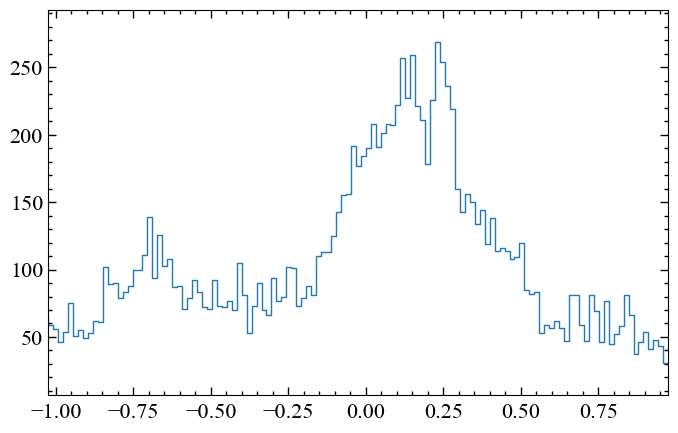

In [91]:
binsize = 0.016
tus_asim = df_asim['tus'].to_numpy()
bins=np.round(np.arange(min(tus_asim), max(tus_asim) + binsize, binsize),3)
counts, edges = np.histogram(tus_asim, bins=bins)
Ti, Tf = edges[:-1], edges[1:]
df_export = pd.DataFrame({'Ti':Ti, 'Tf':Tf, 'Counts': counts})
df_export.to_csv(f'/Users/andreas/phys/master/GRB/xspec/ASIM/light_curves/GRB190305A_HED_{binsize*1e3:.0f}ms',index_label=False,index=False)
plt.step(edges[:-1],counts)
plt.show()

# Cross Corrolation of burst LC

### KW

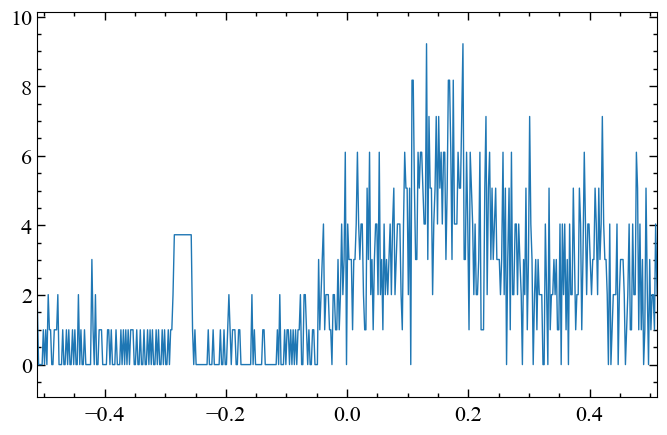

In [85]:
kw_filename = "GRB190305A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>2*binsize)[0][0]

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw], G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

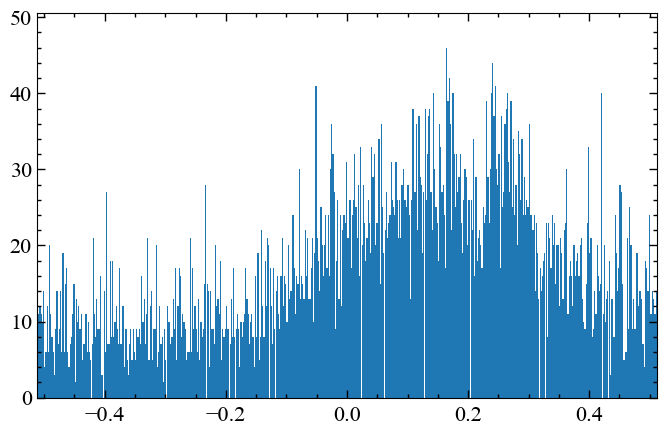

In [86]:
tus = df_asim['tus'].to_numpy(dtype=np.float64)
#bins = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
plt.hist(tus,bins=bins)
plt.show()

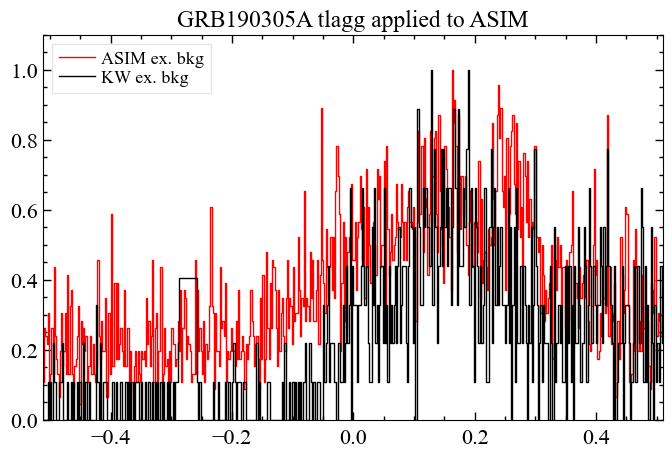

In [87]:
tus_asim = df_asim['tus'].to_numpy()

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)

plt.step(x=asim_edges[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='r')
plt.step(x=bins[:-1],y=G3/max(G3),where='pre',label='KW ex. bkg',c='black')

plt.ylim(bottom=0)
plt.legend()
plt.title("GRB190305A tlagg applied to ASIM")
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

In [88]:
asim_lc = LC(time=asim_edges.astype(np.float32)[:-1]+binsize/2,counts=asim_counts.astype(np.int32),skip_checks=True)
kw_lc = LC(time=bins.astype(np.float32)[:-1]+binsize/2,counts=G3.astype(np.int32),skip_checks=True)
np.all(asim_lc.bin_lo == kw_lc.bin_lo)

True

tlagg_asim: 0.0


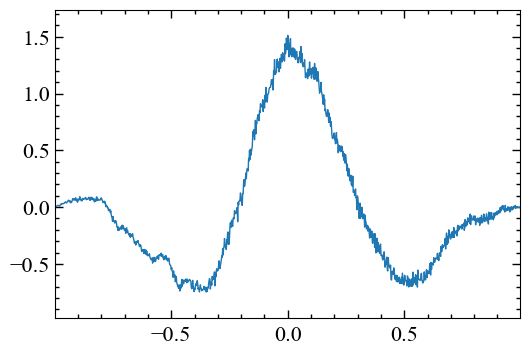

In [89]:
CC_kw_asim = CC(kw_lc,asim_lc,mode='full',norm='variance')
tlagg_asim = CC_kw_asim.time_shift
print(f'tlagg_asim: {tlagg_asim}')
CC_kw_asim.plot()
plt.show()

### HED

In [60]:
df_burst['tus'].to_numpy()

array([-757406.722, -755353.222, -754378.028, ..., 1248033.667,
       1249335.332, 1249338.167])

In [ ]:
tus_burst = df_burst['tus'].to_numpy()/1e6 #converting back to seconds for CC
tus_burst += tlagg_approx
hist = np.histogram(tus_burst,bins=np.append(kw_bin_lo,kw_bin_hi[-1])) #using KW bins
asimCounts,asimEdges = hist[0],hist[1]

plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
plt.title("ASIM")
plt.show()

In [ ]:
asim_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=asimCounts, skip_checks=True,dt=binsize)
asim_lc.plot()
kw_lc.plot()

In [ ]:
CC = CrossCorrelation(kw_lc,asim_lc,mode="full")
CClagg=CC.time_shift
tlagg = tlagg_approx + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg, '  tlagg_approx: ', tlagg_approx)
CC.plot()

In [64]:
tlagg = 0.476
df_burst['tus'] = df_burst['tus'].to_numpy() + tlagg*1e6

In [ ]:
plot_HED(tus_arr=df_burst['tus'].to_numpy(),binsize=16,T0=T0+timedelta(seconds=tlagg))

In [ ]:
df_burst.head()

# SPECTRUM

### BACKGROUND

In [70]:
df_keV_bg = keV_hist(df_asim_bkg,time_interval='max',keV_interval='max')

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  637
n triggers are within bounds  637
keV bins are set for HED
Energies binned!


In [71]:
df_keV_bg.tail()

,bins_keV,counts,poisson_error_counts
36,39810.72,32,5.656854
37,50118.72,1,1.000000
38,63095.73,0,0.000000
39,79432.82,0,0.000000
40,100000.00,0,0.000000


### BURST

In [90]:
df_keV_burst = keV_hist(df_asim_burst,time_interval=(0.768,1.280),keV_interval='max')

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  5753
n triggers are within bounds  5753
keV bins are set for HED
Energies binned!


In [ ]:
df_keV_burst.head(40)

# FITS

In [75]:
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

## BAK

In [76]:
print(T0)
print(min(df_asim_bkg['tus'].to_numpy()),max(df_asim_bkg['tus'].to_numpy()))

2019-03-05 13:05:20.292000
-0.28140672200000005 -0.10535463900000008


In [79]:
#EXPOSURE
print(max(df_asim_bkg['tus'].to_numpy())-min(df_asim_bkg['tus'].to_numpy()))

0.17605208299999997


In [78]:
ra,dec=340.399,-10.588

In [80]:
BAK_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.292','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-0.2814,'[s] Start time of background spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [-0.1053,'End time of background spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.176052,'[s] Integration time in seconds for the BAK data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190305A.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}


In [81]:
generateBAK(BAK_dict=BAK_dict,
            bakCounts=df_keV_bg['counts'][1:].to_numpy(dtype=np.int32),
            stat_err=df_keV_bg['poisson_error_counts'][1:].to_numpy(dtype=np.float32),
            bin_lo=df_keV_bg['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV_bg['bins_keV'][1:].to_numpy(dtype=np.float32)
           )

## PHA

In [91]:
PHA_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.292','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.768,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [1.280,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB190305A.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB190305A.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB190305A.pha','PHA filename'] #<str>  ('example.pha')
}


In [92]:
generatePHA(PHA_dict=PHA_dict,
            counts=df_keV_burst['counts'][1:].to_numpy(dtype=np.int16),
            stat_err=df_keV_burst['poisson_error_counts'][1:].to_numpy(dtype=np.float32),
            bin_lo=df_keV_burst['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV_burst['bins_keV'][1:].to_numpy(dtype=np.float32))

### RSP
    Used from theta,phi angles

In [93]:
theta,phi=133.904,-2.076

In [ ]:
find_DRM_file(dir_path='/Users/andreas/phys/master/HED_DRM/',
             theta=theta,phi=phi)

In [95]:
RSP_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.292','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.768,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [1.280,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190305A.rsp','RSP filename'] #<str>  ('example.pha')
}

In [96]:
generateRSP(RSP_dict=RSP_dict, 
            DRM_fname='HED_drm_mats_135.00_0.00.txt', 
            bin_lo=df_keV_burst['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV_burst['bins_keV'][1:].to_numpy(dtype=np.float32),
            theta=theta,
            phi=phi,
            see_headers=False)